#Installing Detectron2 dependencies

In [0]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 23kB/s 
     |████████████████████████████████| 4.1MB 48.1MB/s 
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Found existing installation: torchvision 0.5.0
    Uninstalling torchvision-0.5.0:
      Successfully uninstalled torchvision-0.5.0
     |████████████████████████████████| 276kB 30.0MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=cf1c257e6e3cd3d16bc03234f7d2ee51b3492be9855c0911b8809fec94151318
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-vrh1xmb3
  Running command git

In [0]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 6.2MB 2.1MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.dev200408-cp36-none-any.whl size=38766 sha256=20daa2d8a1eb5e0b56ecdb241333997d61e70936b105412d533cc11e7e397474
  Stored in directory: /root/.cache/pip/wheels/f4/0e/47/26bf800646b2132b8da459615a0366162ab3380306d3849b7b
Successfully built fvcore


In [0]:
import torch
import torchvision
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Let's try COCO KeyPoint Segmentation on a TikTok Video

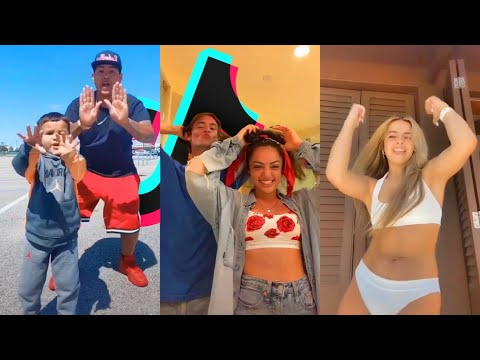

In [0]:
# This is the video we're going to process
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("S5zttDDYGJo", width=500)
display(video)

In [0]:
# Install dependencies, download the video, and crop 15 seconds for processing
!pip install youtube-dl
!pip uninstall -y opencv-python opencv-contrib-python
!apt install python3-opencv  # the one pre-installed have some issues
!youtube-dl https://www.youtube.com/watch?v=S5zttDDYGJo -f 22 -o original_clip.mp4
!ffmpeg -i original_clip.mp4 -t 00:00:05 -c:v copy cropped_clip.mp4

     |████████████████████████████████| 1.8MB 14.5MB/s 
Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
Uninstalling opencv-contrib-python-4.1.2.30:
  Successfully uninstalled opencv-contrib-python-4.1.2.30
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  python3-opencv
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 534 kB of archives.
After this operation, 2,941 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 python3-opencv amd64 3.2.0+dfsg-4ubuntu0.1 [534 kB]
Fetched 534 kB in 1s (514 kB/s)
Selecting previously unselected package python3-opencv.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../python3-opencv_3.2.0+dfsg-4ubuntu0.1_amd64.deb ...
Unpacking python3-opencv (3.2.0+dfsg-4ubuntu0.1) ...
Setting up python3-

In [0]:
!git clone https://github.com/thatguySid/detectron2.git
!python detectron2/demo/demo.py --config-file detectron2/configs/COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml --video-input cropped_clip.mp4 --confidence-threshold 0.6 --output output_clip.mp4 \
  --opts MODEL.WEIGHTS detectron2://COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x/138363331/model_final_997cc7.pkl

Cloning into 'detectron2'...
remote: Enumerating objects: 3643, done.
remote: Total 3643 (delta 0), reused 0 (delta 0), pack-reused 3643
Receiving objects: 100% (3643/3643), 2.16 MiB | 9.75 MiB/s, done.
Resolving deltas: 100% (2521/2521), done.
Failed to load OpenCL runtime
[04/08 23:30:35 detectron2]: Arguments: Namespace(confidence_threshold=0.6, config_file='detectron2/configs/COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml', input=None, opts=['MODEL.WEIGHTS', 'detectron2://COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x/138363331/model_final_997cc7.pkl'], output='output_clip.mp4', video_input='cropped_clip.mp4', webcam=False)
[04/08 23:30:40 fvcore.common.checkpoint]: Loading checkpoint from detectron2://COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x/138363331/model_final_997cc7.pkl
[04/08 23:30:40 fvcore.common.file_io]: Downloading https://dl.fbaipublicfiles.com/detectron2/COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x/138363331/model_final_997cc7.pkl ...
[04/08 23:30:40 fvcore.common.download]: 

In [0]:
from google.colab import files
files.download('output_clip.mp4')

MessageError: ignored

# Getting Keypoint Instances from a Video

In [0]:
"Here we collect the sequence of keypoint coordinates for each instance in the video"
import cv2
import numpy as np
import os, sys
import time

start = time.time()
frames = []
kpts = []
frame_count = 0
# Colab GPU fits 3 images at once
batch_size = 1

# Setup directory
ROOT_DIR = os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
VIDEO_DIR = os.path.join(ROOT_DIR, "videos")
VIDEO_SAVE_DIR = os.path.join(VIDEO_DIR, "save")

# Start video capture
capture = cv2.VideoCapture('output_clip.mp4')
try:
  if not os.path.exists(VIDEO_SAVE_DIR):
    os.makedirs(VIDEO_SAVE_DIR)
  if (capture.isOpened()== False): 
    print("Error opening video stream or file")
except OSError:
  print ('Error: Creating directory of data')

capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

# Set the model configs
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
end_init = time.time()

print(f'Initialization took {end_init - start} s')
# Processing the video in batches
while True:
  ret, frame = capture.read()
  if not ret:
    break

  frame_count += 1
  frames.append(frame)
  print('frame_count :{0}'.format(frame_count))
  
  if len(frames) == batch_size:
    tmp_start = time.time()
    inpt = [{'image': torch.from_numpy(x).float().permute(2,0,1), 'height':1080, 'width':1920} for x in frames]
    outputs = predictor.model(inpt)
    kpts.append(outputs[0]['instances'].pred_keypoints)
    tmp_end = time.time()
    print(f'Processing {batch_size} many frames took {tmp_end - tmp_start} s')
    # Clear the frames array to start the next batch
    frames=[]

end = time.time()
print(f'Processing all frames took {end_init - end}') 
# When everything done, release the video capture
capture.release()
cv2.destroyAllWindows()
print('Task Finished')

Initialization took 1.5702712535858154 s
frame_count :1
Processing 1 many frames took 0.2250828742980957 s
frame_count :2
Processing 1 many frames took 0.2196519374847412 s
frame_count :3
Processing 1 many frames took 0.2141714096069336 s
frame_count :4
Processing 1 many frames took 0.21187543869018555 s
frame_count :5
Processing 1 many frames took 0.21009087562561035 s
frame_count :6
Processing 1 many frames took 0.21186041831970215 s
frame_count :7
Processing 1 many frames took 0.21210670471191406 s
frame_count :8
Processing 1 many frames took 0.21338272094726562 s
frame_count :9
Processing 1 many frames took 0.2135922908782959 s
frame_count :10
Processing 1 many frames took 0.2197103500366211 s
frame_count :11
Processing 1 many frames took 0.21678590774536133 s
frame_count :12
Processing 1 many frames took 0.21356892585754395 s
frame_count :13
Processing 1 many frames took 0.2101600170135498 s
frame_count :14
Processing 1 many frames took 0.21169471740722656 s
frame_count :15
Proces

In [0]:
for x in kpts:
  print(x.shape)

torch.Size([3, 17, 3])
torch.Size([4, 17, 3])
torch.Size([4, 17, 3])
torch.Size([3, 17, 3])
torch.Size([3, 17, 3])
torch.Size([3, 17, 3])
torch.Size([3, 17, 3])
torch.Size([3, 17, 3])
torch.Size([3, 17, 3])
torch.Size([3, 17, 3])
torch.Size([2, 17, 3])
torch.Size([2, 17, 3])
torch.Size([2, 17, 3])
torch.Size([3, 17, 3])
torch.Size([4, 17, 3])
torch.Size([3, 17, 3])
torch.Size([3, 17, 3])
torch.Size([3, 17, 3])
torch.Size([3, 17, 3])
torch.Size([3, 17, 3])
torch.Size([3, 17, 3])
torch.Size([3, 17, 3])
torch.Size([3, 17, 3])
torch.Size([3, 17, 3])
torch.Size([3, 17, 3])
torch.Size([3, 17, 3])
torch.Size([3, 17, 3])
torch.Size([3, 17, 3])
torch.Size([4, 17, 3])
torch.Size([3, 17, 3])
torch.Size([2, 17, 3])
torch.Size([2, 17, 3])
torch.Size([2, 17, 3])
torch.Size([3, 17, 3])
torch.Size([2, 17, 3])
torch.Size([3, 17, 3])
torch.Size([3, 17, 3])
torch.Size([3, 17, 3])
torch.Size([3, 17, 3])
torch.Size([3, 17, 3])
torch.Size([3, 17, 3])
torch.Size([4, 17, 3])
torch.Size([5, 17, 3])
torch.Size(

In [0]:
kpts_0 = [x[0] for x in kpts] 

In [0]:
res = torch.FloatTensor([1920, 1080, 1]).unsqueeze(0).unsqueeze(0).cuda()

In [0]:
res.shape

torch.Size([1, 1, 3])

In [0]:

kpts_tensor = torch.stack(kpts_0, dim=0)

In [0]:
standard_kpts = [x/res for x in kpts]

In [0]:
kpts[0].shape

torch.Size([3, 17, 3])

In [0]:
standard_kpts = kpts_tensor / res

In [0]:
height = 100
num_frames = len(standard_kpts)
width = 100
pose_video = np.zeros([num_frames, height, width])
for i in range(num_frames):
    for instance in standard_kpts[i]:
      for coord in instance:
          x_tmp = round(coord[0].item() * width)
          y_tmp = round(coord[1].item() * height)
          pose_video[i, y_tmp, x_tmp] = 1

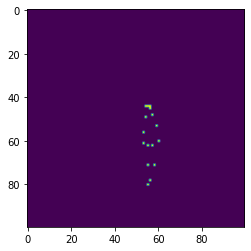

In [0]:
import matplotlib.pyplot as plt

plt.imshow(pose_frame)

In [0]:
print(kpts_tensor[0][0])

tensor([1.0659e+03, 4.8462e+02, 1.7894e-01], device='cuda:0')


In [0]:

from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# np array with shape (frames, height, width, channels)

fig = plt.figure()
im = plt.imshow(pose_video[0,:,:])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(pose_video[0,:,:])

def animate(i):
    im.set_data(pose_video[i,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=pose_video.shape[0],
                               interval=50)
HTML(anim.to_html5_video())

In [0]:
from IPython.display import HTML

HTML(anim.to_html5_video())

In [0]:
predictor??

In [0]:
outputs[0]['instances'].pred_keypoints.shape

torch.Size([2, 17, 3])

In [0]:
predictor.model??

In [0]:
!pkill python

In [0]:
!nvidia-smi

Wed Apr  8 23:57:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    25W /  75W |   7393MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  